In [7]:
import pandas as pd
import numpy as np
from histr import Shabdansh
from typing import List

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

import jax
import jax.numpy as jnp
from jax import random

In [8]:
import sys
sys.path.append("../")

In [9]:
from parse_names import get_top_n_names, generate_grapheme_mapping

In [10]:
# read in all the words
words = get_top_n_names()
words[:8]

/home/khandelia1000/naam/notebooks/../parse_names.py:33: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  names = names.sort_values(by=["count"], ascending=False)["name"][:n].tolist()


['राम',
 'पुत्र',
 'राजेन्द्र',
 'राजाराम',
 'ओमप्रकाश',
 'अब्दुल',
 'छोटेलाल',
 'सीताराम']

In [11]:
len(words)

32000

In [12]:
stoi, itos = generate_grapheme_mapping(words)
unique_syallable_count = len(stoi)
print(itos)

{1: 'अ', 2: 'अँ', 3: 'अं', 4: 'अा', 5: 'अॅ', 6: 'अो', 7: 'अौ', 8: 'आ', 9: 'आं', 10: 'आे', 11: 'आै', 12: 'इ', 13: 'इं', 14: 'ई', 15: 'उ', 16: 'ऊ', 17: 'ऊं', 18: 'ऋ', 19: 'ऋृ', 20: 'ए', 21: 'एै', 22: 'ऐ', 23: 'ओ', 24: 'ओं', 25: 'ओे', 26: 'ओै', 27: 'औ', 28: 'औं', 29: 'क', 30: 'कँ', 31: 'कं', 32: 'का', 33: 'कां', 34: 'कि', 35: 'किं', 36: 'की', 37: 'कु', 38: 'कुँ', 39: 'कुं', 40: 'कुॅ', 41: 'कू', 42: 'कृ', 43: 'के', 44: 'कै', 45: 'को', 46: 'कौ', 47: 'क्क', 48: 'क्का', 49: 'क्की', 50: 'क्कु', 51: 'क्कू', 52: 'क्के', 53: 'क्ख', 54: 'क्खा', 55: 'क्खि', 56: 'क्खी', 57: 'क्खु', 58: 'क्खू', 59: 'क्खे', 60: 'क्खो', 61: 'क्छे', 62: 'क्ट', 63: 'क्टू', 64: 'क्त', 65: 'क्ता', 66: 'क्ति', 67: 'क्ती', 68: 'क्ते', 69: 'क्फ', 70: 'क्म', 71: 'क्मा', 72: 'क्मि', 73: 'क्मी', 74: 'क्या', 75: 'क्यू', 76: 'क्र', 77: 'क्रा', 78: 'क्रां', 79: 'क्रि', 80: 'क्री', 81: 'क्रु', 82: 'क्रे', 83: 'क्ला', 84: 'क्श', 85: 'क्शी', 86: 'क्शू', 87: 'क्ष', 88: 'क्षा', 89: 'क्षि', 90: 'क्षी', 91: 'क्षु', 92: 'क्षू', 93: 'क्षे',

In [13]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
purna_virama = "।"
def build_dataset(words):  
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in list(w) + [purna_virama]:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([129377, 3]) torch.Size([129377])
torch.Size([16142, 3]) torch.Size([16142])
torch.Size([16141, 3]) torch.Size([16141])


In [14]:
from jax import random
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap

In [15]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([129377, 3]), torch.Size([129377]))

In [16]:
# Define the shapes of the parameters
emb_dim = 10
block_size = 3
input_dim = emb_dim * block_size
params_shapes = [(unique_syallable_count, emb_dim), (input_dim, 200), (200,), (200, unique_syallable_count), (unique_syallable_count,)]

In [17]:
# Initialize the parameters with random values
key = random.PRNGKey(2147483647)
params = []
for shape in params_shapes:
    key, subkey = random.split(key)
    params.append(random.normal(subkey, shape))

param_count = sum(x.size for x in jax.tree_leaves(params))
param_count

/tmp/ipykernel_356279/4087364666.py:8: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  param_count = sum(x.size for x in jax.tree_leaves(params))


279656

In [18]:
device_count = jax.device_count()

In [19]:
from functools import partial

In [20]:
# Define the loss function with vmap
@partial(vmap, in_axes=(None, 0, 0))
def loss_fn(params, X, Y):
    C, W1, b1, W2, b2 = params
    emb = C[X]
    h = jnp.tanh(emb.reshape(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = -jnp.mean(jax.nn.log_softmax(logits)[jnp.arange(Y.shape[0]), Y], axis=-1)
    return loss

# Define the update function
@jit
def update(params, X, Y, lr):
    def reduce_loss_fn(params, X_reshaped, Y_reshaped):
        loss = jnp.mean(loss_fn(params, X_reshaped, Y_reshaped))
        return loss

    grad_fn = jit(grad(reduce_loss_fn))
    X_reshaped = jnp.reshape(X, (device_count, -1, block_size))
    Y_reshaped = jnp.reshape(Y, (device_count, -1))
    loss = loss_fn(params, X_reshaped, Y_reshaped)
    grads = grad_fn(params, X_reshaped, Y_reshaped)
    params = [p - lr * g for p, g in zip(params, grads)]
    return params, loss

In [21]:
# Convert the PyTorch tensors to numpy arrays
Xtr = np.array(Xtr)
Ytr = np.array(Ytr)

# Define the learning rate schedule
lre = jnp.linspace(-3, 0, 1000)
lrs = 10**lre

# Define the lists to store the training statistics
stepi = []
lossi = []

In [22]:
from jax_smi import initialise_tracking
initialise_tracking()

In [23]:
# Train the model
batch_size = 128
minibatch_count = 200000
for i in range(minibatch_count):
    # Select a minibatch
    ix = np.random.choice(Xtr.shape[0], size=batch_size, replace=False)
    X, Y = Xtr[ix], Ytr[ix]
    
    # Update the learning rate
    lr = 0.1 if i < 100000 else 0.01
    
    # Update the parameters and record the loss
    params, loss = update(params, X, Y, lr)
    if not i % 100:
        print(f"At Step {i}: {jnp.mean(loss)}")
    
    # Record the statistics
    stepi.append(i)
    lossi.append(jnp.log10(jnp.mean(loss)))

At Step 0: 42.29022216796875
At Step 100: 23.855239868164062
At Step 200: 23.482486724853516
At Step 300: 17.879711151123047
At Step 400: 14.54261302947998
At Step 500: 11.882031440734863
At Step 600: 12.296037673950195
At Step 700: 10.816970825195312
At Step 800: 9.54721736907959
At Step 900: 9.22022819519043
At Step 1000: 9.369779586791992
At Step 1100: 7.866896629333496
At Step 1200: 7.354220867156982
At Step 1300: 7.616824150085449
At Step 1400: 7.590457916259766
At Step 1500: 7.127158164978027
At Step 1600: 5.822206974029541
At Step 1700: 6.958062171936035
At Step 1800: 6.095047950744629
At Step 1900: 7.00297212600708
At Step 2000: 7.373416423797607
At Step 2100: 7.236603736877441
At Step 2200: 7.1734771728515625
At Step 2300: 5.624959945678711
At Step 2400: 5.2863898277282715
At Step 2500: 5.079425811767578
At Step 2600: 6.617570877075195
At Step 2700: 5.69627571105957
At Step 2800: 5.494747638702393
At Step 2900: 6.692240238189697
At Step 3000: 6.405323028564453
At Step 3100: 5.

At Step 25100: 3.597425937652588
At Step 25200: 4.045978546142578
At Step 25300: 3.616766929626465
At Step 25400: 3.348642349243164
At Step 25500: 3.5282490253448486
At Step 25600: 3.802896738052368
At Step 25700: 3.962214708328247
At Step 25800: 3.8134372234344482
At Step 25900: 3.482513189315796
At Step 26000: 3.792034149169922
At Step 26100: 3.7338013648986816
At Step 26200: 3.8149938583374023
At Step 26300: 3.486386775970459
At Step 26400: 4.120576858520508
At Step 26500: 3.947587013244629
At Step 26600: 3.2529547214508057
At Step 26700: 3.840395927429199
At Step 26800: 4.014047622680664
At Step 26900: 3.7329142093658447
At Step 27000: 3.8902747631073
At Step 27100: 3.884267568588257
At Step 27200: 3.579087734222412
At Step 27300: 4.182285308837891
At Step 27400: 3.7956535816192627
At Step 27500: 3.4973220825195312
At Step 27600: 3.3357951641082764
At Step 27700: 4.069927215576172
At Step 27800: 4.140811920166016
At Step 27900: 3.399977684020996
At Step 28000: 3.754737615585327
At 

At Step 49700: 3.7094132900238037
At Step 49800: 3.3337531089782715
At Step 49900: 3.2074320316314697
At Step 50000: 3.6126575469970703
At Step 50100: 3.1265313625335693
At Step 50200: 3.194753646850586
At Step 50300: 3.3893072605133057
At Step 50400: 4.22007942199707
At Step 50500: 3.6110479831695557
At Step 50600: 3.8001937866210938
At Step 50700: 3.643512487411499
At Step 50800: 3.6912035942077637
At Step 50900: 3.611776351928711
At Step 51000: 3.7552318572998047
At Step 51100: 3.4418275356292725
At Step 51200: 4.307721138000488
At Step 51300: 3.5522141456604004
At Step 51400: 3.642723798751831
At Step 51500: 3.15450382232666
At Step 51600: 3.8727619647979736
At Step 51700: 3.565566062927246
At Step 51800: 3.665942668914795
At Step 51900: 3.8610429763793945
At Step 52000: 3.8216402530670166
At Step 52100: 3.8810839653015137
At Step 52200: 3.2845299243927
At Step 52300: 3.760786533355713
At Step 52400: 3.7474305629730225
At Step 52500: 3.7890608310699463
At Step 52600: 3.499390125274

At Step 74200: 3.8540432453155518
At Step 74300: 3.7999167442321777
At Step 74400: 3.6172406673431396
At Step 74500: 3.345442771911621
At Step 74600: 3.176193952560425
At Step 74700: 3.988499641418457
At Step 74800: 3.6659374237060547
At Step 74900: 3.3157575130462646
At Step 75000: 3.671743869781494
At Step 75100: 3.571908473968506
At Step 75200: 3.1187448501586914
At Step 75300: 3.1921420097351074
At Step 75400: 3.130218982696533
At Step 75500: 2.9054648876190186
At Step 75600: 3.1869609355926514
At Step 75700: 3.398289680480957
At Step 75800: 3.3348543643951416
At Step 75900: 3.489255428314209
At Step 76000: 3.1891441345214844
At Step 76100: 3.426919460296631
At Step 76200: 3.592921257019043
At Step 76300: 2.9664454460144043
At Step 76400: 3.3240323066711426
At Step 76500: 3.7667436599731445
At Step 76600: 3.3768796920776367
At Step 76700: 3.543896436691284
At Step 76800: 3.431666851043701
At Step 76900: 3.4196691513061523
At Step 77000: 3.74088716506958
At Step 77100: 3.60996723175

At Step 98700: 3.7419614791870117
At Step 98800: 3.603078842163086
At Step 98900: 3.2001614570617676
At Step 99000: 3.137878894805908
At Step 99100: 3.418029308319092
At Step 99200: 3.20298433303833
At Step 99300: 3.39663028717041
At Step 99400: 3.309521198272705
At Step 99500: 3.2839322090148926
At Step 99600: 3.279539108276367
At Step 99700: 3.117262601852417
At Step 99800: 3.748465061187744
At Step 99900: 3.400813102722168
At Step 100000: 3.0674166679382324
At Step 100100: 2.9164938926696777
At Step 100200: 3.2834372520446777
At Step 100300: 3.1284916400909424
At Step 100400: 3.4169771671295166
At Step 100500: 3.654266357421875
At Step 100600: 3.263378381729126
At Step 100700: 3.010248899459839
At Step 100800: 3.7282865047454834
At Step 100900: 3.0426199436187744
At Step 101000: 2.9425954818725586
At Step 101100: 3.5541396141052246
At Step 101200: 3.5713186264038086
At Step 101300: 3.498260498046875
At Step 101400: 3.4785289764404297
At Step 101500: 3.5446527004241943
At Step 101600

At Step 122600: 3.4160497188568115
At Step 122700: 3.139336585998535
At Step 122800: 3.024331569671631
At Step 122900: 3.0483129024505615
At Step 123000: 3.6787900924682617
At Step 123100: 3.541945695877075
At Step 123200: 3.268357276916504
At Step 123300: 3.5408592224121094
At Step 123400: 3.60837459564209
At Step 123500: 3.560670852661133
At Step 123600: 3.0049238204956055
At Step 123700: 3.0148673057556152
At Step 123800: 3.8995282649993896
At Step 123900: 3.3304316997528076
At Step 124000: 3.3094968795776367
At Step 124100: 3.323835849761963
At Step 124200: 3.87861967086792
At Step 124300: 3.138986110687256
At Step 124400: 3.379124164581299
At Step 124500: 3.1774849891662598
At Step 124600: 3.6313488483428955
At Step 124700: 3.1066954135894775
At Step 124800: 3.264531135559082
At Step 124900: 3.4854795932769775
At Step 125000: 3.6880831718444824
At Step 125100: 3.3258442878723145
At Step 125200: 3.266683578491211
At Step 125300: 3.6468658447265625
At Step 125400: 3.595531940460205


At Step 146400: 3.3602805137634277
At Step 146500: 3.3260200023651123
At Step 146600: 3.379672050476074
At Step 146700: 3.0320560932159424
At Step 146800: 3.1435465812683105
At Step 146900: 3.421815872192383
At Step 147000: 3.386676788330078
At Step 147100: 3.214489459991455
At Step 147200: 3.5824594497680664
At Step 147300: 3.3435912132263184
At Step 147400: 3.296297311782837
At Step 147500: 2.9188132286071777
At Step 147600: 3.427497386932373
At Step 147700: 2.676842451095581
At Step 147800: 3.668893337249756
At Step 147900: 3.466231346130371
At Step 148000: 3.23897123336792
At Step 148100: 3.105433940887451
At Step 148200: 2.92730712890625
At Step 148300: 3.2934377193450928
At Step 148400: 3.430662155151367
At Step 148500: 3.320366382598877
At Step 148600: 3.2613720893859863
At Step 148700: 3.4709649085998535
At Step 148800: 3.568021535873413
At Step 148900: 3.135294198989868
At Step 149000: 3.664085865020752
At Step 149100: 3.1976864337921143
At Step 149200: 3.52775239944458
At Ste

At Step 170200: 3.5570850372314453
At Step 170300: 3.454097270965576
At Step 170400: 3.1660468578338623
At Step 170500: 3.3444392681121826
At Step 170600: 3.524501323699951
At Step 170700: 3.2070987224578857
At Step 170800: 3.3359055519104004
At Step 170900: 3.6927237510681152
At Step 171000: 3.4218010902404785
At Step 171100: 3.7253334522247314
At Step 171200: 3.3711180686950684
At Step 171300: 3.0739357471466064
At Step 171400: 3.4222826957702637
At Step 171500: 3.4738929271698
At Step 171600: 3.3154659271240234
At Step 171700: 2.831993818283081
At Step 171800: 3.273437023162842
At Step 171900: 3.241983652114868
At Step 172000: 3.5351476669311523
At Step 172100: 3.260568141937256
At Step 172200: 3.1474170684814453
At Step 172300: 3.787217140197754
At Step 172400: 2.9981253147125244
At Step 172500: 3.142951011657715
At Step 172600: 3.7146103382110596
At Step 172700: 3.476793050765991
At Step 172800: 3.504128932952881
At Step 172900: 3.0778801441192627
At Step 173000: 3.256470918655395

At Step 194000: 3.4416966438293457
At Step 194100: 3.529411792755127
At Step 194200: 3.6342763900756836
At Step 194300: 3.237424612045288
At Step 194400: 3.766004800796509
At Step 194500: 3.38040828704834
At Step 194600: 3.7876386642456055
At Step 194700: 3.386523723602295
At Step 194800: 3.1072280406951904
At Step 194900: 3.619957208633423
At Step 195000: 3.189815044403076
At Step 195100: 3.567831516265869
At Step 195200: 3.2624988555908203
At Step 195300: 3.246828556060791
At Step 195400: 3.0074586868286133
At Step 195500: 3.3779494762420654
At Step 195600: 3.3971078395843506
At Step 195700: 3.4717886447906494
At Step 195800: 3.3372650146484375
At Step 195900: 3.3936705589294434
At Step 196000: 3.1748619079589844
At Step 196100: 3.185037136077881
At Step 196200: 3.365556240081787
At Step 196300: 3.6986594200134277
At Step 196400: 3.378507614135742
At Step 196500: 3.2360072135925293
At Step 196600: 3.1191985607147217
At Step 196700: 3.6951611042022705
At Step 196800: 3.114619016647339

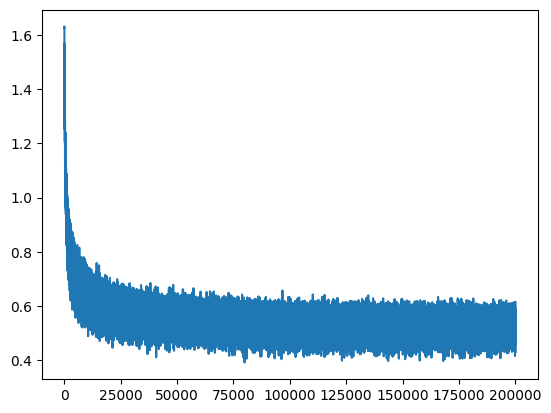

In [24]:
plt.plot(stepi, lossi)

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [23]:
def get_probs(params, context):
    C, W1, b1, W2, b2 = params
    emb = C[jnp.array(context)]
    h = jnp.tanh(emb.reshape(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    return np.asarray(jax.nn.softmax(logits, axis=1))

In [24]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        probs = torch.from_numpy(get_probs(params, context))
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

/tmp/ipykernel_246423/4020137744.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  probs = torch.from_numpy(get_probs(params, context))


अंरयारअली।
भूकदी।
तदेव।
पदसुसिहं।
नेब्बानाथ।
सुतना।
वाहनसिंह।
राजब।
रलाई।
बीनेचर।
हजना।
शोन्सा।
कौविफेम।
कुमाध।
सुमुजतदयालसिह।
जोरामुशी।
विधुयति।
घकुखो।
मैलेति।
शिव।


In [27]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        probs = torch.from_numpy(get_probs(params, context))
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

अंर।
देरकापा।
कदीलाल।
वज्यपचसिंह।
न्जनेवस्साथरखां।
रामवाचूउनक्षूवल।
बगर।
अकी।
विचर।
हननाथ।
विब्बासैम्हान्कूफेछांश्रसँब्बेवन्नीस्सुहीलोसुंअच्चीशार।
जोरमु।
कोलन।
नोररीन्द।
नकीनान।
शिव।
नानैलाल।
फूरेखैस्तीव्याठेभो।
मुरीर।
सोसान्जूर।


In [49]:
probs.shape

torch.Size([32, 1296])